In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import glob
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [2]:
PATH = "G:/dataset/panicle_period/"
train_dir = os.path.join(PATH, 'train')
val_dir = os.path.join(PATH, 'val')
test_dir = os.path.join(PATH, 'test')

BATCH_SIZE = 32
IMG_SIZE = (224, 224)

train_dataset = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                             shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE)

Found 39688 files belonging to 3 classes.


In [3]:
val_dataset = tf.keras.preprocessing.image_dataset_from_directory(val_dir,
                                                  shuffle=True,
                                                  batch_size=BATCH_SIZE,
                                                  image_size=IMG_SIZE)
test_dataset = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                  shuffle=True,
                                                  batch_size=BATCH_SIZE,
                                                  image_size=IMG_SIZE)

Found 13231 files belonging to 3 classes.
Found 13231 files belonging to 3 classes.


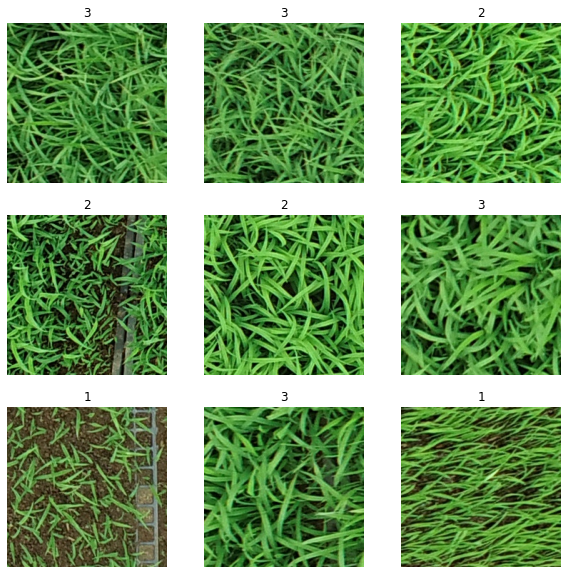

In [4]:
class_names = train_dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [5]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
val_dataset = val_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

In [6]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
  tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
])

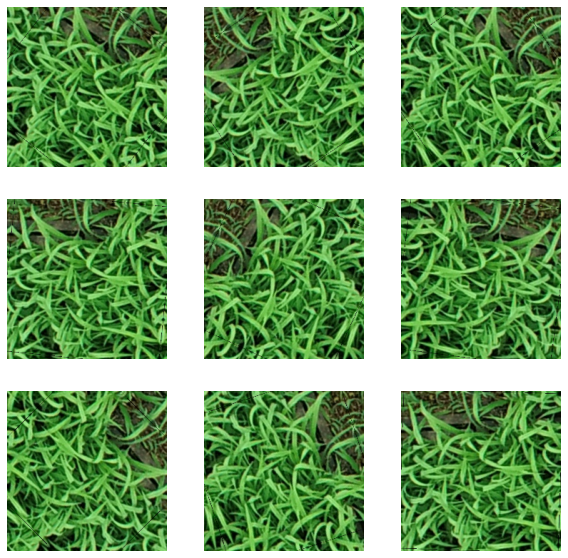

In [7]:
for image, _ in train_dataset.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

In [8]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

In [9]:
rescale = tf.keras.layers.experimental.preprocessing.Rescaling(1./127.5, offset= -1)

In [10]:
# Create the base model from the pre-trained model MobileNet V2
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

In [11]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 7, 7, 1280)


In [12]:
base_model.trainable = False

In [13]:
base_model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 225, 225, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
_______________________________________________________________________________

In [14]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1280)


In [15]:
prediction_layer = tf.keras.layers.Dense(3)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 3)


In [16]:
inputs = tf.keras.Input(shape=(224, 224, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [17]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [18]:
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 224, 224, 3)       0         
_________________________________________________________________
tf_op_layer_RealDiv (TensorF [(None, 224, 224, 3)]     0         
_________________________________________________________________
tf_op_layer_Sub (TensorFlowO [(None, 224, 224, 3)]     0         
_________________________________________________________________
mobilenetv2_1.00_224 (Functi (None, 7, 7, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1280)             

In [19]:
len(model.trainable_variables)

2

In [20]:
initial_epochs = 10
history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=val_dataset)

Epoch 1/10
1241/1241 [==============================] - 130s 105ms/step - loss: 0.4655 - accuracy: 0.8075 - val_loss: 0.3877 - val_accuracy: 0.8319
Epoch 2/10
1241/1241 [==============================] - 129s 104ms/step - loss: 0.3393 - accuracy: 0.8636 - val_loss: 0.3169 - val_accuracy: 0.8702
Epoch 3/10
1241/1241 [==============================] - 116s 93ms/step - loss: 0.3034 - accuracy: 0.8775 - val_loss: 0.2916 - val_accuracy: 0.8798
Epoch 4/10
1241/1241 [==============================] - 130s 105ms/step - loss: 0.2853 - accuracy: 0.8864 - val_loss: 0.2780 - val_accuracy: 0.8853
Epoch 5/10
1241/1241 [==============================] - 133s 107ms/step - loss: 0.2766 - accuracy: 0.8890 - val_loss: 0.2644 - val_accuracy: 0.8913
Epoch 6/10
1241/1241 [==============================] - 123s 99ms/step - loss: 0.2655 - accuracy: 0.8957 - val_loss: 0.2619 - val_accuracy: 0.8922
Epoch 7/10
1241/1241 [==============================] - 125s 101ms/step - loss: 0.2624 - accuracy: 0.8964 - val_lo

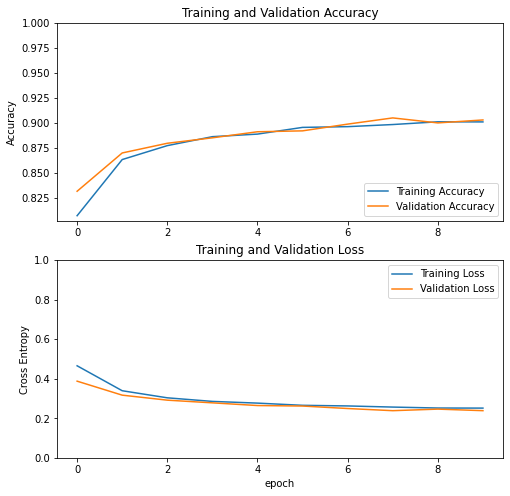

In [21]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

[-3.3706472  -1.1374975   1.76759    -4.5617642   4.0207615  -3.829742
 -4.9230103  -0.91642934  2.5090394  -2.5580344   2.4996636  -4.408039
 -3.344136    0.11746943 -0.5019897   0.2239765   1.3345551  -4.3874836
 -5.7999253   0.4364981   0.48222125 -6.589771   -0.26329753  3.6361973
 -6.5953045  -0.65747684  3.2348745  -3.4994633   1.4339094  -2.9770355
 -4.251732    3.2811828  -3.1776986  -6.0744243   1.8679336   1.3346496
  1.2973124  -0.05568961 -4.3716393  -3.2851157   2.9533987  -3.39776
 -2.149695    0.58947    -2.407749   -5.784592    0.16588724  1.7303622
 -0.92765516  3.514597   -6.1643267  -7.0683513   2.143546   -0.05822756
 -4.998013    1.0882555   0.33378187 -5.3305764  -0.43224218  2.6169064
  0.82488006  0.29873702 -3.1171038  -0.9468139  -0.04665831 -2.3506212
 -2.5541706  -0.30358115  0.15754887 -7.3604503   1.2486972   2.143203
 -6.830773   -0.2683591   1.8993607  -5.8427877   3.2858014  -0.85846156
 -2.8922539   3.5927367  -3.2118375  -4.619006   -0.9107108   1.161

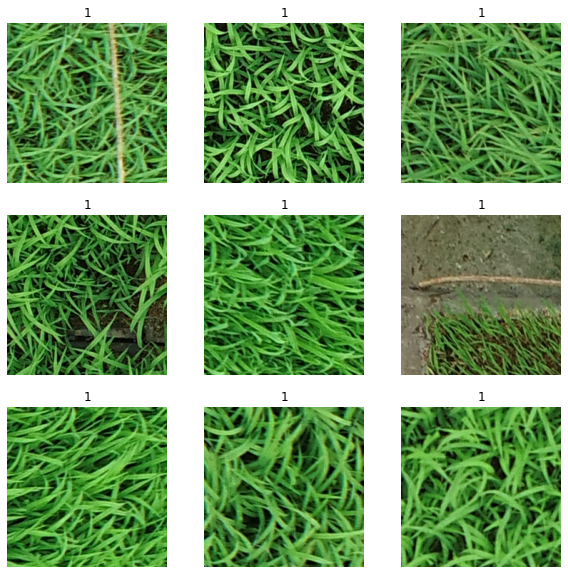

In [30]:
#Retrieve a batch of images from the test set
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch).flatten()
print(predictions)
print(np.argmax(predictions))

# Apply a sigmoid since our model returns logits
# predictions = tf.nn.sigmoid(predictions)
# img_array = tf.expand_dims(img_array, 0)
# predictions = model.predict(img_array)
predictions = tf.nn.softmax(predictions)
predictions = tf.where(predictions < 0.5, 0, 1)

print('Predictions:\n', predictions.numpy())
print('Labels:\n', label_batch)

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(class_names[predictions[i]])
  plt.axis("off")